Import Data

In [174]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_stata("callreports_final.dta", chunksize=100000, preserve_dtypes=True)

df_raw = pd.DataFrame()

for chunk in data:
    df_raw=df_raw.append(chunk)

Additional Settings

In [199]:
%matplotlib inline
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.ticker as ticker

pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 18

plt.style.use('default')


plt.rcParams['font.size']=BIGGER_SIZE          # controls default text sizes
plt.rcParams['axes.titlesize']=BIGGER_SIZE     # fontsize of the axes title
plt.rcParams['axes.labelsize']=BIGGER_SIZE    # fontsize of the x and y labels
plt.rcParams['xtick.labelsize']=BIGGER_SIZE    # fontsize of the tick labels
plt.rcParams['ytick.labelsize']=BIGGER_SIZE    # fontsize of the tick labels
plt.rcParams['legend.fontsize']=BIGGER_SIZE    # legend fontsize
plt.rcParams['figure.titlesize']=BIGGER_SIZE  # fontsize of the figure title

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

#removing Goldman Sachs and Morgan Stanley
df_raw = df_raw[(df_raw.rssdid!=1456501) & (df_raw.bhcid!=2380443)]

In [175]:
df = df_raw[["name", "bhcid", "rssdid","assets",'year', "quarter", "equity"]]


df_indBanks = df[df.bhcid == 0]


df = df[df.bhcid != 0]
df = df.groupby(["bhcid","year", "quarter"]).agg({"assets":"sum",
                                  "equity":"sum"})

df["leverageRatio"] = df.assets/df.equity

#rename bhcid to rssdid
df.index.names = ["rssdid", "year", "quarter"]

df_indBanks["leverageRatio"] = df_indBanks.assets/df_indBanks.equity
df_indBanks.set_index([df_indBanks.rssdid, df_indBanks.year, df_indBanks.quarter], inplace=True)
df_indBanks = df_indBanks[["assets", "equity", "leverageRatio"]]
#df_indBanks.drop(["rssdid", "bhcid", "year"], axis=1, inplace=True)
#df
df_all_raw = pd.concat([df, df_indBanks])

In [176]:
df_all = df_all_raw.copy()
df_all.leverageRatio.replace([np.inf, -np.inf], np.nan, inplace=True)
df_all.dropna(how="all", subset=["leverageRatio"],inplace=True)

df_all = df_all[df_all.leverageRatio>0] #removing all negativ leverageRatios
df_all_noIndex = df_all.reset_index()
df_all_noIndex

,rssdid,year,quarter,assets,equity,leverageRatio
0,128146.0,1976.0,1.0,10986.0,956.0,11.491632
1,128146.0,1976.0,2.0,11870.0,1030.0,11.524272
2,128146.0,1976.0,3.0,11410.0,1061.0,10.754006
3,128146.0,1976.0,4.0,11559.0,1049.0,11.019066
4,128146.0,1977.0,1.0,11936.0,1068.0,11.176030
...,...,...,...,...,...,...
1312423,4262543.0,2013.0,2.0,742574.0,168484.0,4.407386
1312424,4262543.0,2013.0,3.0,770830.0,170330.0,4.525509
1312425,4262543.0,2013.0,4.0,808999.0,168617.0,4.797850
1312426,4536084.0,2013.0,4.0,35356.0,15989.0,2.211270


Datasets for top 0.1%, 1%, 5%, 50%

In [261]:
year = 1976

topOnePercent = pd.DataFrame()
topFivePercent = pd.DataFrame()
topTenPercent = pd.DataFrame()
topFiftyPercent = pd.DataFrame()

for i in range(38):
    quarter=1
    temp_df_year = df_all_noIndex[df_all_noIndex.year==year]
    #print(year)
    
    for j in range(4):
        #print(quarter)
        temp_df = temp_df_year[temp_df_year.quarter==quarter]
        temp_df = temp_df.sort_values(by=["assets"], ascending=False )
        #print(len(temp_df))
        onepercent = round(0.001*len(temp_df))
        fivepercent = round(0.01*len(temp_df))
        tenpercent = round(0.10*len(temp_df))
        fiftypercent = round(0.50*len(temp_df))
        #print(onepercent)
        temp_df_One = temp_df.iloc[:onepercent,:]
        temp_df_Five = temp_df.iloc[:fivepercent, :]
        temp_df_Ten = temp_df.iloc[:tenpercent, :]
        temp_df_Fifty = temp_df.iloc[:fiftypercent, :]
        topOnePercent = topOnePercent.append(temp_df_One)
        topFivePercent = topFivePercent.append(temp_df_Five)
        topTenPercent = topTenPercent.append(temp_df_Ten)
        topFiftyPercent = topFiftyPercent.append(temp_df_Fifty)
        quarter = quarter + 1
    
    year = year + 1

Median LeverageRatio

In [274]:
df_aggOnePercent = topOnePercent.groupby(["year", "quarter"]).median()
df_aggFivePercent = topFivePercent.groupby(["year", "quarter"]).median()
df_aggTenPercent = topTenPercent.groupby(["year", "quarter"]).median()
df_aggFiftyPercent = topFiftyPercent.groupby(["year", "quarter"]).median()

df_all_grouped = df_all.groupby(["year", "quarter"]).median()
df_all_grouped_mean = df_all.groupby(["year", "quarter"]).mean()

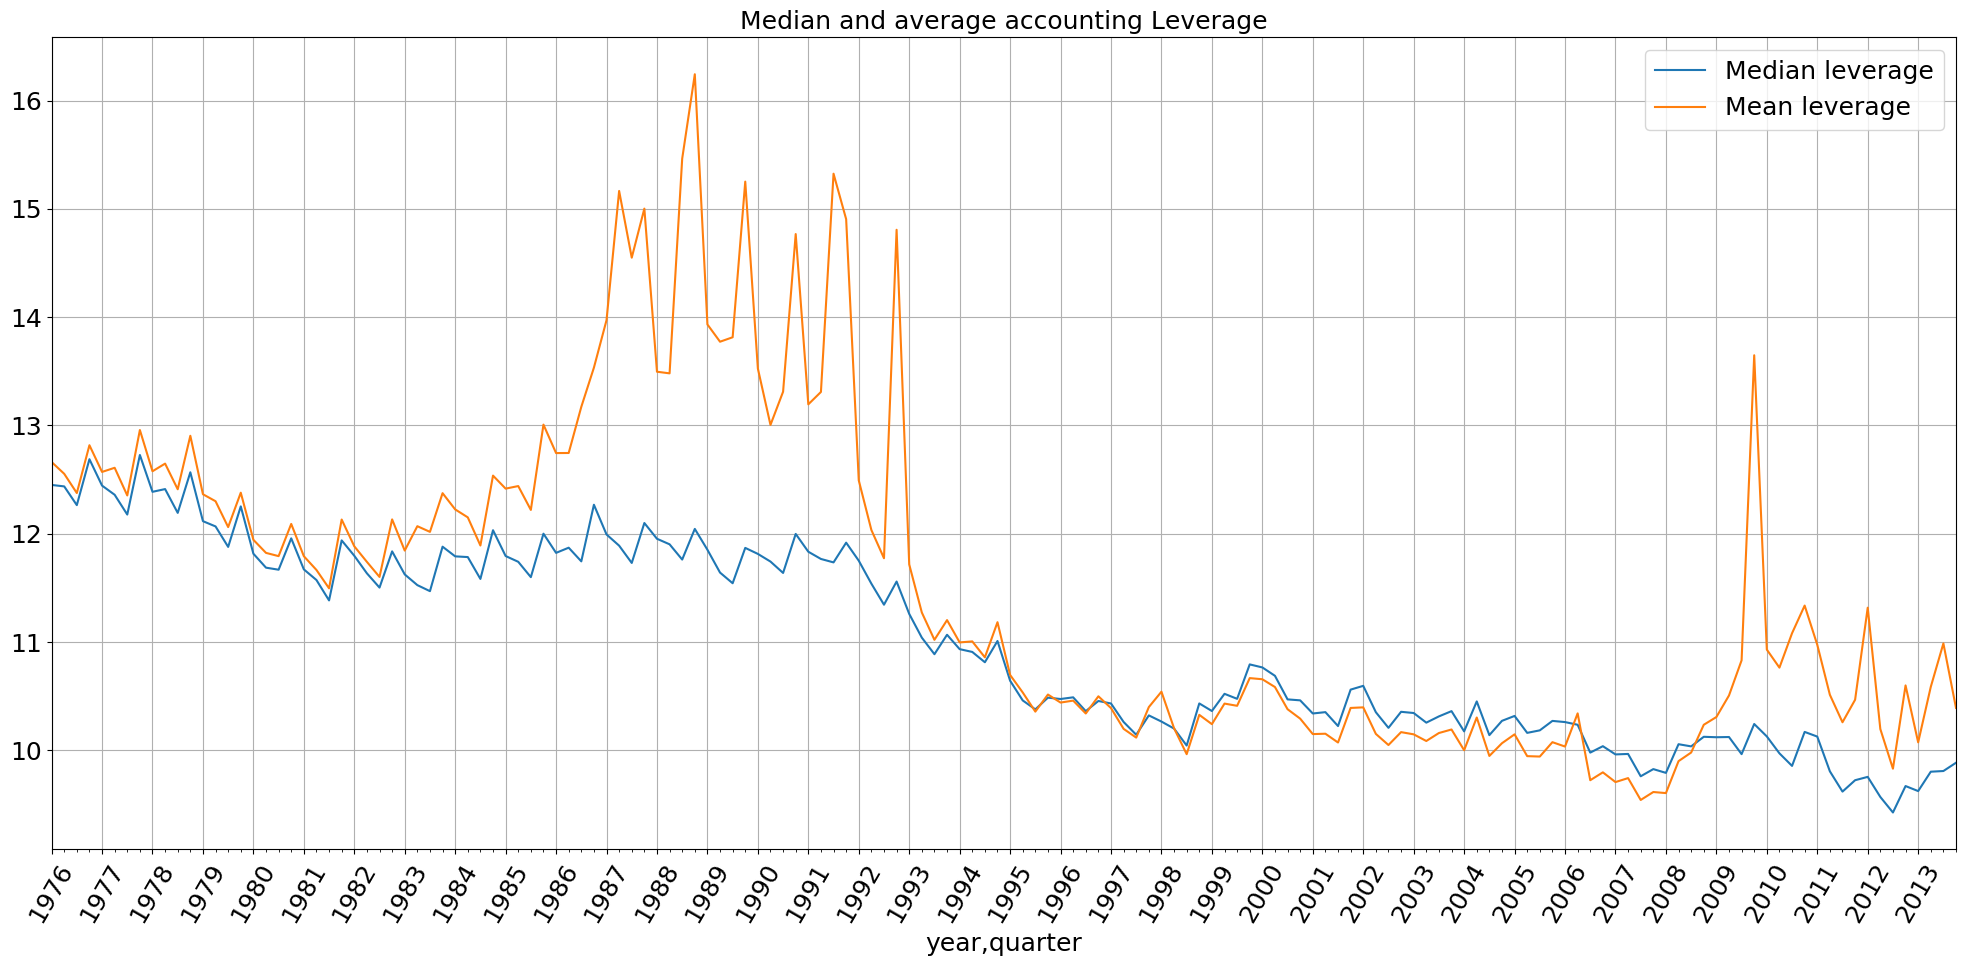

In [276]:
fig, ax = plt.subplots(figsize=(20,10))

#set labels
ax.set_xlabel("Year")
ax.set_title("Median and average accounting Leverage")


#plot
df_all_grouped.plot(ax=ax, y=["leverageRatio"])
df_all_grouped_mean.plot(ax=ax, y=["leverageRatio"])
#set xaxis ticks
years = [str(year) for year in range(1976, 2014)]
ax.set_xticks(range(0,152,4))
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.grid()
ax.set_xticklabels(years, rotation=60)
ax.set_xlim(0,151)

#legend
ax.legend(["Median leverage", "Mean leverage"])


plt.tight_layout()
plt.savefig('LatexVorlage/graphs/NewLeverage_LeverageRatioAllBanks_7613.png')

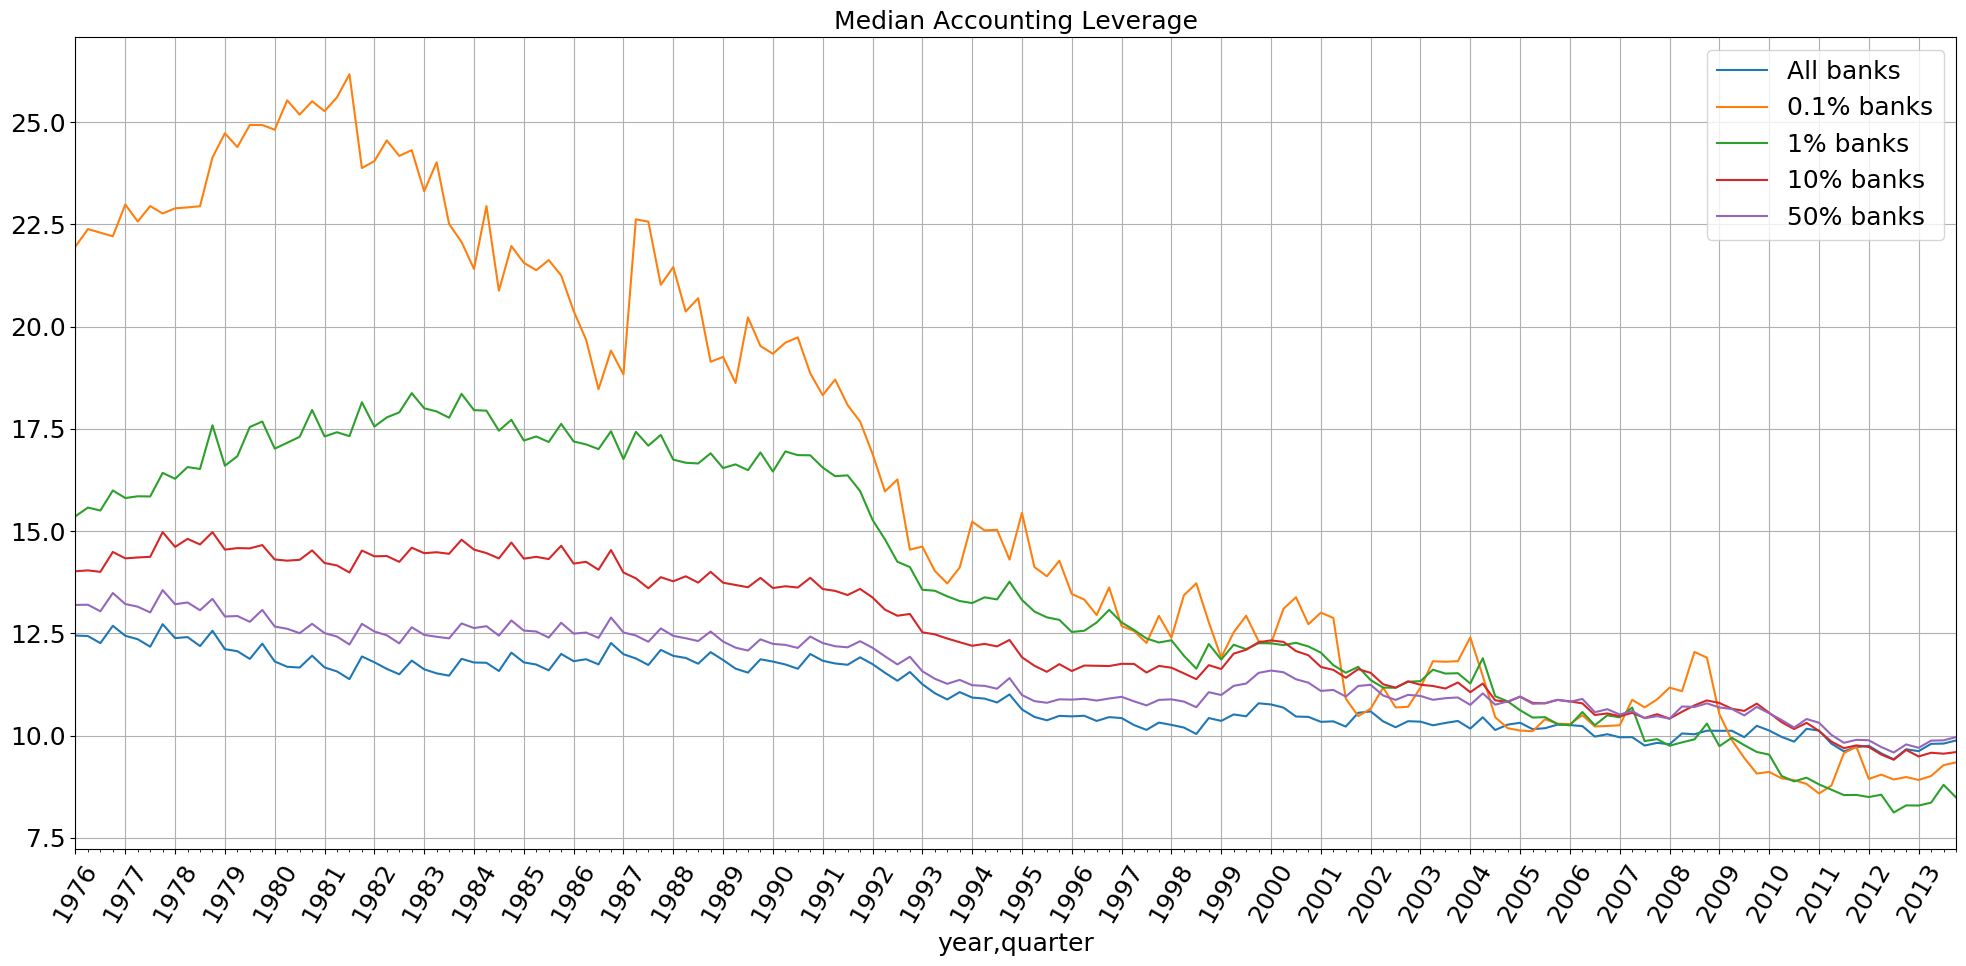

In [263]:



fig, ax = plt.subplots(figsize=(20,10))
#ax.set_xticks(df_years_mean.index)
#ax.set_xticklabels(df_years_mean.index, rotation=60)
ax.set_xlabel("Year")
ax.set_title("Median Accounting Leverage")

years = [str(year) for year in range(1976, 2014)]
ax.set_xticks(range(0,152,4))

ax.xaxis.set_minor_locator(AutoMinorLocator(4))

df_all_grouped.leverageRatio.plot(ax=ax)
df_aggOnePercent.leverageRatio.plot(ax=ax)
df_aggFivePercent.leverageRatio.plot(ax=ax)
df_aggTenPercent.leverageRatio.plot(ax=ax)
df_aggFiftyPercent.leverageRatio.plot(ax=ax)
ax.legend(["All banks", "0.1% banks", "1% banks", "10% banks", "50% banks"])

ax.set_xticklabels(years, rotation=60)
#ax.plot(df_all_grouped.leverageRatio,"g-")
#ax.plot(df_all_grouped.leverageRatio,"oy")
#ax.xaxis.set_major_locator(plt.MaxNLocator(10))
#ax.xaxis.set_minor_locator(plt.FixedLocator(8))
ax.set_xlim(0,151)

ax.grid(True)

plt.tight_layout()
plt.savefig('LatexVorlage/graphs/NewLeverage_LeverageRatioMedian_7613.png')

In [264]:
df1 = pd.concat([df_all_grouped.leverageRatio,df_aggOnePercent.leverageRatio, df_aggFivePercent.leverageRatio, 
                   df_aggTenPercent.leverageRatio, df_aggFiftyPercent.leverageRatio], axis=1)


df1.corr()

,leverageRatio,leverageRatio,leverageRatio,leverageRatio,leverageRatio
leverageRatio,1.000000,0.916309,0.930650,0.964320,0.982880
leverageRatio,0.916309,1.000000,0.951761,0.955780,0.931403
leverageRatio,0.930650,0.951761,1.000000,0.981126,0.935335
leverageRatio,0.964320,0.955780,0.981126,1.000000,0.978623
leverageRatio,0.982880,0.931403,0.935335,0.978623,1.000000


Mean Leverage Ratio

In [265]:
df_aggOnePercent = topOnePercent.groupby(["year", "quarter"]).mean()
df_aggFivePercent = topFivePercent.groupby(["year", "quarter"]).mean()
df_aggTenPercent = topTenPercent.groupby(["year", "quarter"]).mean()
df_aggFiftyPercent = topFiftyPercent.groupby(["year", "quarter"]).mean()

In [266]:
df_all_grouped = df_all.groupby(["year", "quarter"]).mean() #computing average leverage per year and quarter

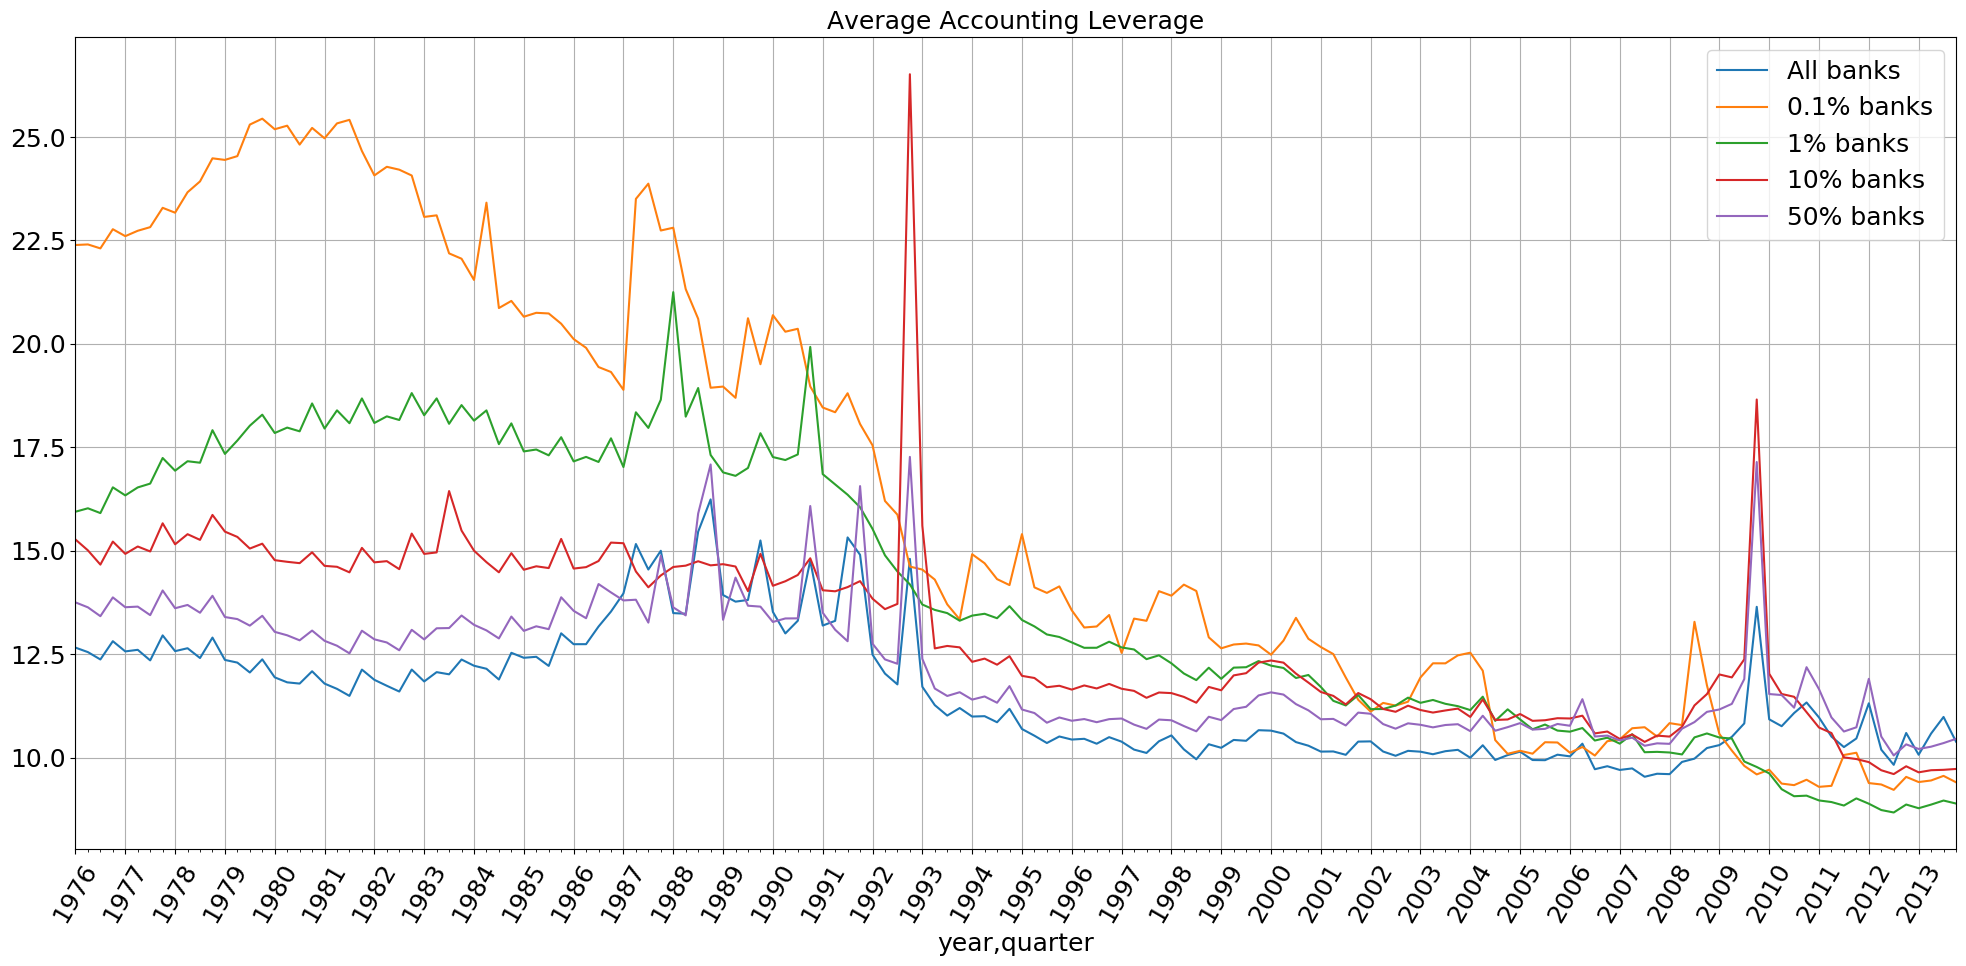

In [267]:



fig, ax = plt.subplots(figsize=(20,10));
#ax.set_xticks(df_years_mean.index)
#ax.set_xticklabels(df_years_mean.index, rotation=60)
ax.set_xlabel("Year")
ax.set_title("Average Accounting Leverage")

years = [str(year) for year in range(1976, 2014)]
ax.set_xticks(range(0,152,4))

ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.grid()
df_all_grouped.leverageRatio.plot(ax=ax)
df_aggOnePercent.leverageRatio.plot(ax=ax)
df_aggFivePercent.leverageRatio.plot(ax=ax)
df_aggTenPercent.leverageRatio.plot(ax=ax)
df_aggFiftyPercent.leverageRatio.plot(ax=ax)
ax.legend(["All banks", "0.1% banks", "1% banks", "10% banks", "50% banks"])

ax.set_xticklabels(years, rotation=60)
#ax.plot(df_all_grouped.leverageRatio,"g-")
#ax.plot(df_all_grouped.leverageRatio,"oy")
#ax.xaxis.set_major_locator(plt.MaxNLocator(10))
#ax.xaxis.set_minor_locator(plt.FixedLocator(8))

ax.set_xlim(0,151)

ax.grid(True)

plt.tight_layout()
plt.savefig('LatexVorlage/graphs/NewLeverage_LeverageRatioMean_7613.png')

Trends

In [237]:
df_aggOnePercent = topOnePercent.groupby(["year", "quarter"]).median()
df_aggFivePercent = topFivePercent.groupby(["year", "quarter"]).median()
df_aggTenPercent = topTenPercent.groupby(["year", "quarter"]).median()
df_aggFiftyPercent = topFiftyPercent.groupby(["year", "quarter"]).median()

df_all_grouped = df_all.groupby(["year", "quarter"]).median()

[Text(0, 0, '1976'),
 Text(0, 0, '1977'),
 Text(0, 0, '1978'),
 Text(0, 0, '1979'),
 Text(0, 0, '1980'),
 Text(0, 0, '1981'),
 Text(0, 0, '1982'),
 Text(0, 0, '1983'),
 Text(0, 0, '1984'),
 Text(0, 0, '1985'),
 Text(0, 0, '1986'),
 Text(0, 0, '1987'),
 Text(0, 0, '1988'),
 Text(0, 0, '1989'),
 Text(0, 0, '1990'),
 Text(0, 0, '1991'),
 Text(0, 0, '1992'),
 Text(0, 0, '1993'),
 Text(0, 0, '1994'),
 Text(0, 0, '1995'),
 Text(0, 0, '1996'),
 Text(0, 0, '1997'),
 Text(0, 0, '1998'),
 Text(0, 0, '1999'),
 Text(0, 0, '2000'),
 Text(0, 0, '2001'),
 Text(0, 0, '2002'),
 Text(0, 0, '2003'),
 Text(0, 0, '2004'),
 Text(0, 0, '2005'),
 Text(0, 0, '2006'),
 Text(0, 0, '2007'),
 Text(0, 0, '2008'),
 Text(0, 0, '2009'),
 Text(0, 0, '2010'),
 Text(0, 0, '2011'),
 Text(0, 0, '2012'),
 Text(0, 0, '2013')]

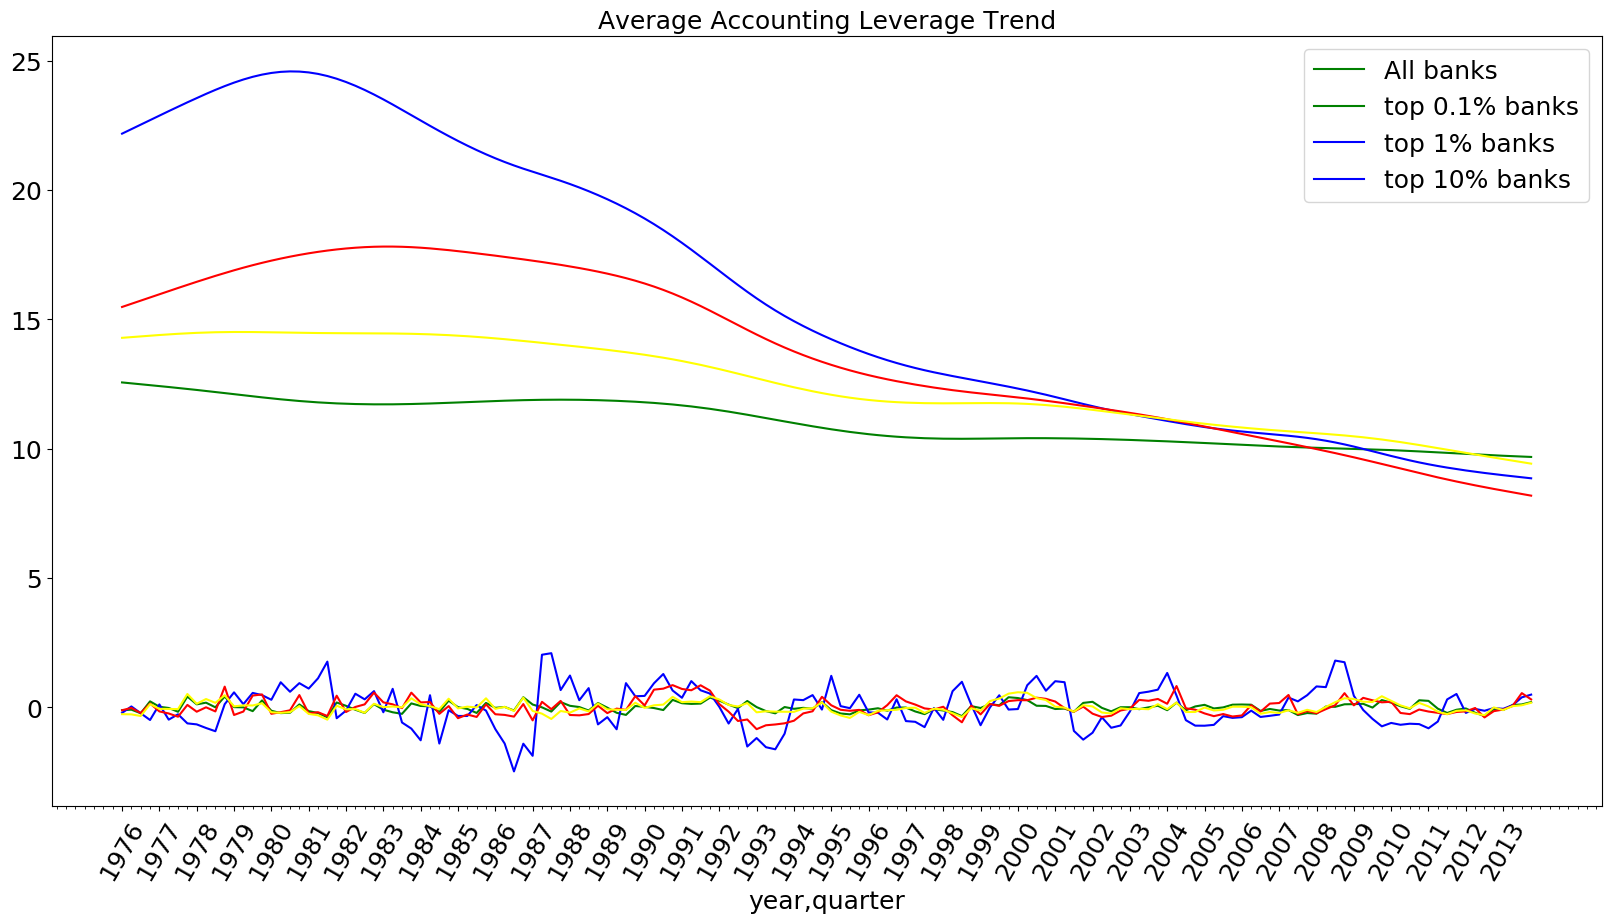

In [238]:
fig, ax = plt.subplots(figsize=(20,10));
#ax.set_xticks(df_years_mean.index)
#ax.set_xticklabels(df_years_mean.index, rotation=60)
ax.set_xlabel("Year")
ax.set_title("Average Accounting Leverage Trend")

colormap = plt.get_cmap('YlGn', 1)
colormap1 = plt.get_cmap('Reds', 1)
colormap2 = plt.get_cmap('Blues', 1)
colormap3 = plt.get_cmap('Greens', 1)

years = [str(year) for year in range(1976, 2014)]
ax.set_xticks(range(0,152,4))

ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.grid()
#df_all_grouped.leverageRatio.plot(ax=ax)
cycle, trend = sm.tsa.filters.hpfilter(df_all_grouped.leverageRatio, 1600)
trend.plot(ax=ax, color="green")
cycle.plot(ax=ax, color="green")
cycle, trend = sm.tsa.filters.hpfilter(df_aggOnePercent.leverageRatio, 1600)
trend.plot(ax=ax,color="blue")
cycle.plot(ax=ax, color="blue")
cycle, trend = sm.tsa.filters.hpfilter(df_aggFivePercent.leverageRatio, 1600)
trend.plot(ax=ax, color="red")
cycle.plot(ax=ax, color="red")
cycle, trend = sm.tsa.filters.hpfilter(df_aggTenPercent.leverageRatio, 1600)
trend.plot(ax=ax, color="yellow")
cycle.plot(ax=ax, color="yellow")
ax.legend(["All banks", "top 0.1% banks", "top 1% banks", "top 10% banks"])

ax.set_xticklabels(years, rotation=60)
#ax.plot(df_all_grouped.leverageRatio,"g-")
#ax.plot(df_all_grouped.leverageRatio,"oy")
#ax.xaxis.set_major_locator(plt.MaxNLocator(10))
#ax.xaxis.set_minor_locator(plt.FixedLocator(8))
#plt.tight_layout()
#plt.savefig('LatexVorlage/graphs/NewLeverage_LeverageRatioTrends_7613.png')

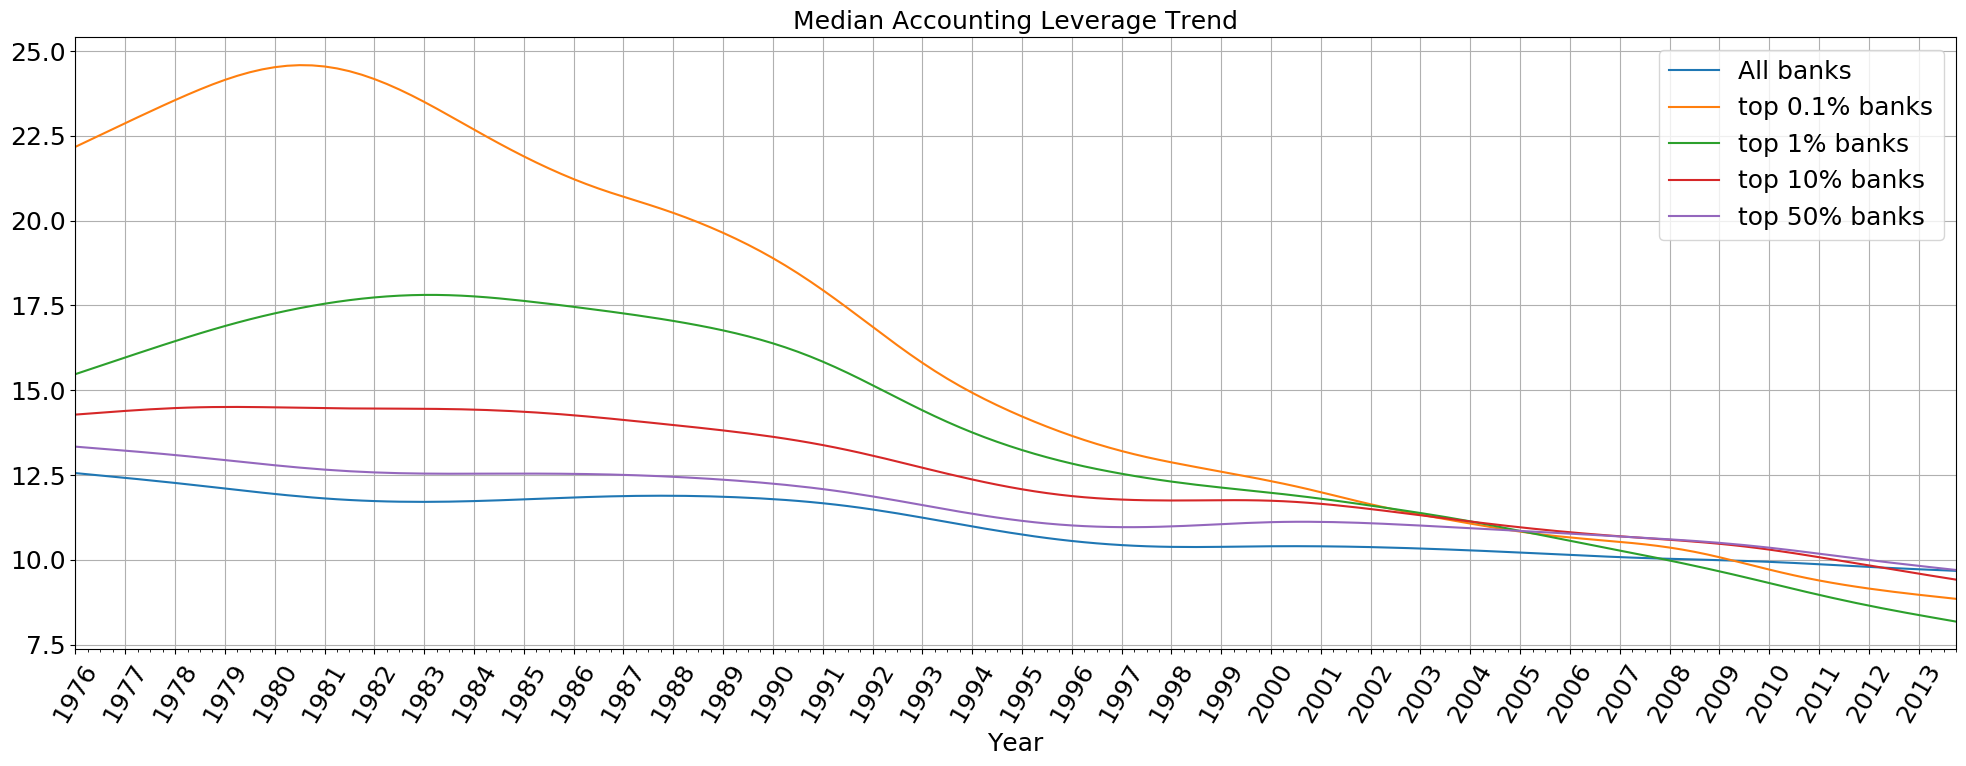

In [239]:
fig, ax = plt.subplots(figsize=(20,8))







#compute filter and plot
cycle, trend = sm.tsa.filters.hpfilter(df_all_grouped.leverageRatio, 1600)
trend.plot(ax=ax)
#cycle.plot(ax=ax[1])
cycle, trend = sm.tsa.filters.hpfilter(df_aggOnePercent.leverageRatio, 1600)
trend.plot(ax=ax)
#cycle.plot(ax=ax[1])
cycle, trend = sm.tsa.filters.hpfilter(df_aggFivePercent.leverageRatio, 1600)
trend.plot(ax=ax)
#cycle.plot(ax=ax[1])
cycle, trend = sm.tsa.filters.hpfilter(df_aggTenPercent.leverageRatio, 1600)
trend.plot(ax=ax)
#cycle.plot(ax=ax[1])
cycle, trend = sm.tsa.filters.hpfilter(df_aggFiftyPercent.leverageRatio, 1600)
trend.plot(ax=ax)
#cycle.plot(ax=ax[1])

#first plot settings
ax.set_xlabel("Year")
ax.set_title("Median Accounting Leverage Trend")
ax.legend(["All banks", "top 0.1% banks", "top 1% banks", "top 10% banks", "top 50% banks"])
years = [str(year) for year in range(1976, 2014)]
ax.set_xticks(range(0,152,4))
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.grid()
ax.set_xticklabels(years, rotation=60)
ax.set_xlim(0,151)

'''
#second plot settings
ax[1].set_xlabel("Year")
ax[1].set_title("Median Accounting Leverage Cyclical")
ax[1].legend(["All banks", "top 0.1% banks", "top 1% banks", "top 10% banks", "top 50% banks"])
years = [str(year) for year in range(1976, 2014)]
ax[1].set_xticks(range(0,152,4))
ax[1].xaxis.set_minor_locator(AutoMinorLocator(4))
ax[1].grid()
ax[1].set_xticklabels(years, rotation=60)
ax[1].set_xlim(0,151)
'''


plt.tight_layout()
plt.savefig('LatexVorlage/graphs/NewLeverage_LeverageRatioTrends_7613.png')

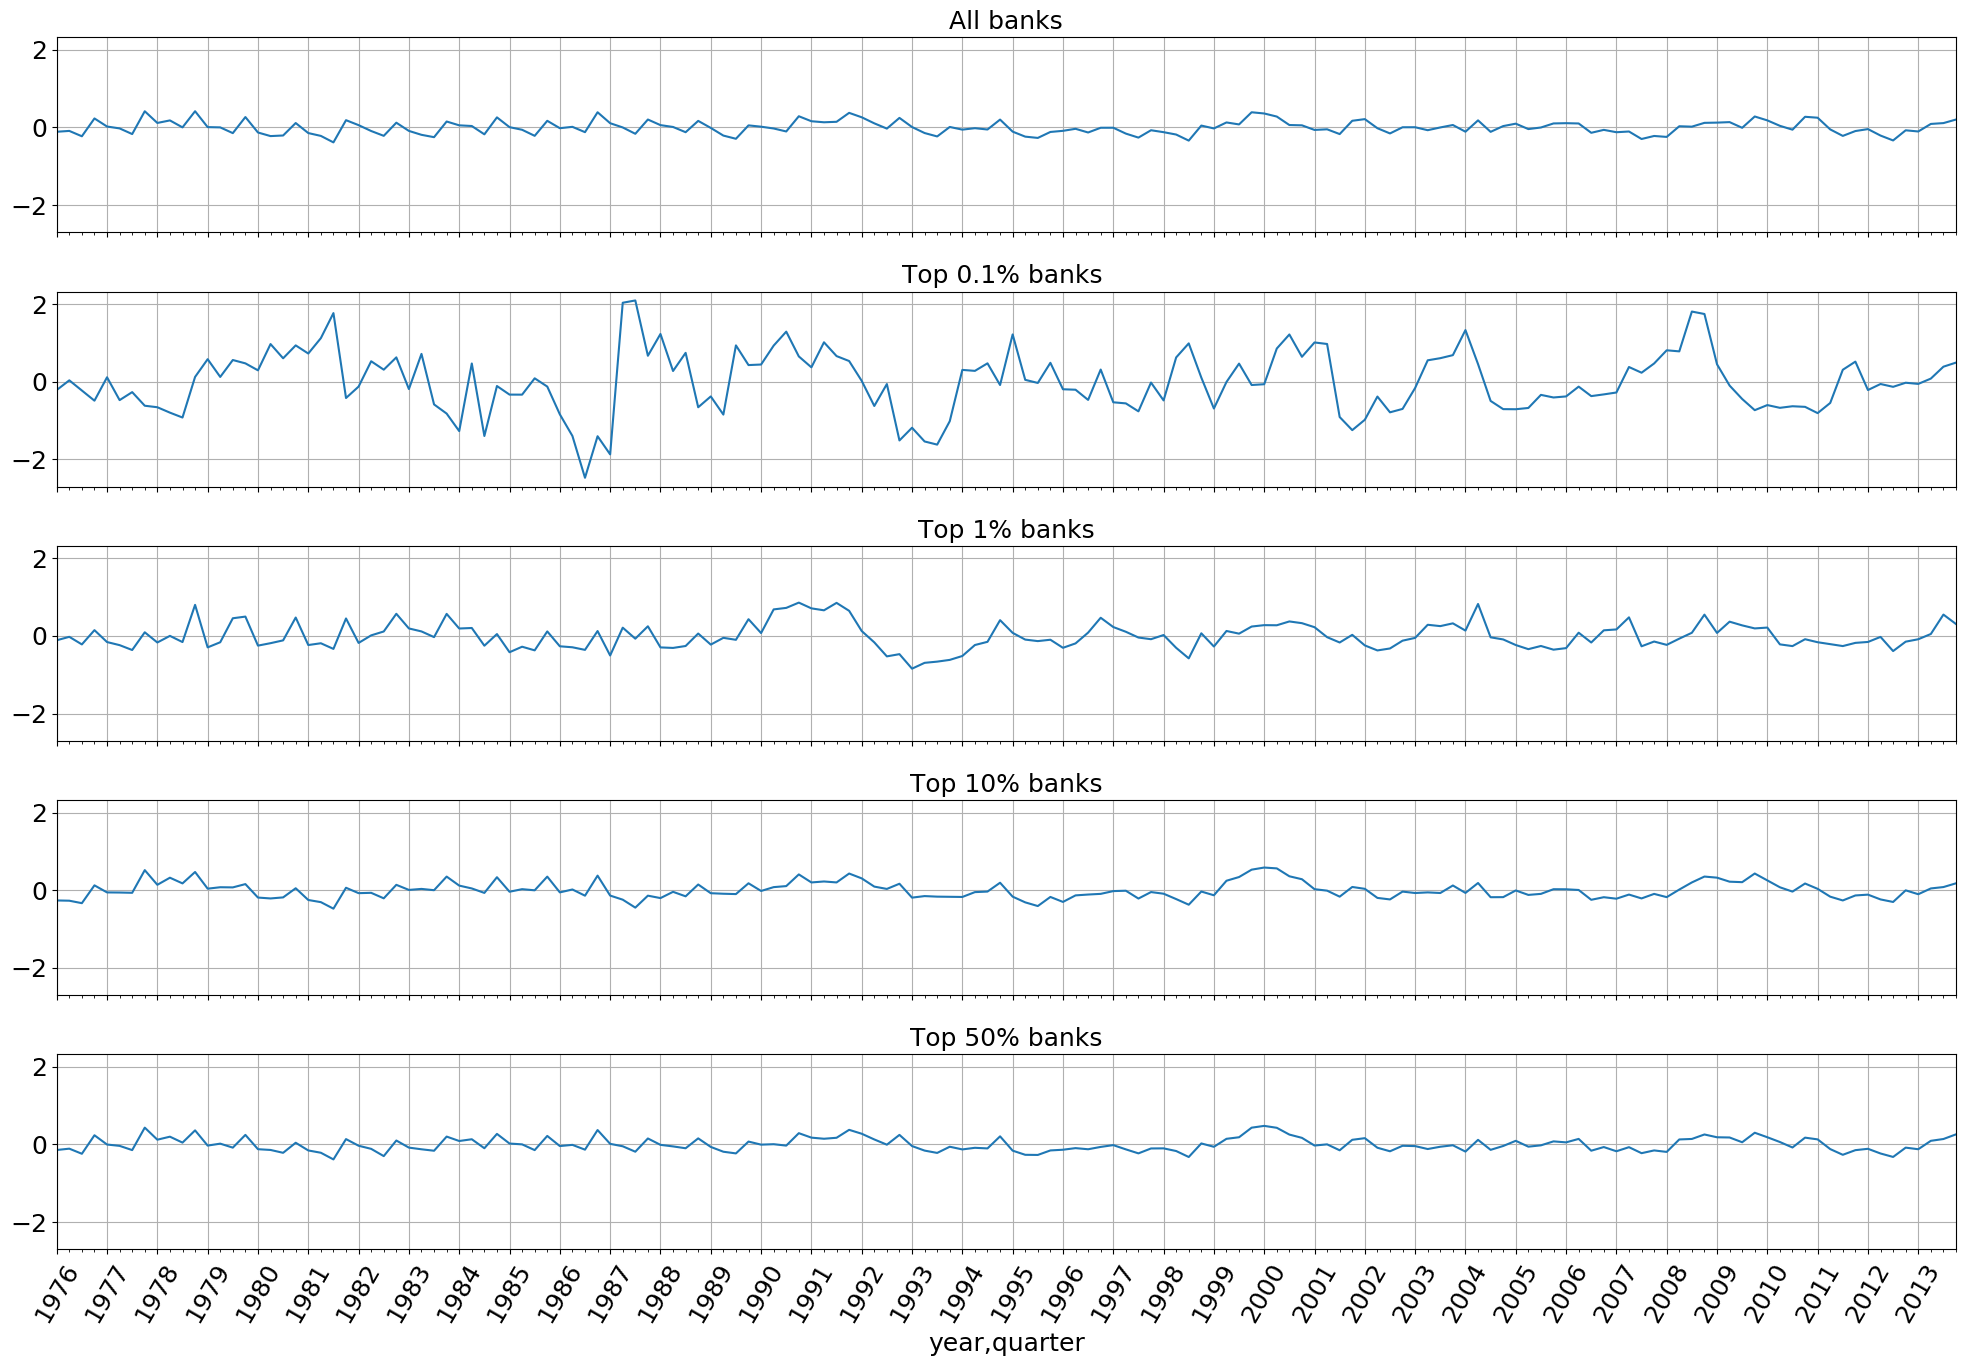

In [240]:
fig, ax = plt.subplots(5,1,figsize=(20,14), sharex=True, sharey=True)
ax.ravel()

#compute filter and plot
cycle_all, trend_all = sm.tsa.filters.hpfilter(df_all_grouped.leverageRatio, 1600)
cycle_all.plot(ax=ax[0])
cycle01, trend01 = sm.tsa.filters.hpfilter(df_aggOnePercent.leverageRatio, 1600)
cycle01.plot(ax=ax[1])
cycle1, trend1 = sm.tsa.filters.hpfilter(df_aggFivePercent.leverageRatio, 1600)
cycle1.plot(ax=ax[2])
cycle10, trend10 = sm.tsa.filters.hpfilter(df_aggTenPercent.leverageRatio, 1600)
cycle10.plot(ax=ax[3])
cycle50, trend50 = sm.tsa.filters.hpfilter(df_aggFiftyPercent.leverageRatio, 1600)
cycle50.plot(ax=ax[4])

#set titles
ax[0].set_title("All banks")
ax[1].set_title("Top 0.1% banks ")
ax[2].set_title("Top 1% banks")
ax[3].set_title("Top 10% banks")
ax[4].set_title("Top 50% banks")

#set xaxis
ax[4].set_xticks(range(0,152,4))
ax[4].xaxis.set_minor_locator(AutoMinorLocator(4))
ax[4].set_xticklabels(years, rotation=60)
ax[4].set_xlim(0,151)

#set grid
for i in range(0,5):
    ax[i].grid(True)



plt.tight_layout()
plt.savefig('LatexVorlage/graphs/NewLeverage_LeverageRatioCyclical_7613.png')

Correlation Cycle

In [242]:
frame = { 'Top 0.1%': cycle01, 'Top 1%': cycle1, 
         'Top 10%': cycle10, 'Top 50%': cycle50,'all': cycle_all  } 

df_corr = pd.DataFrame(frame)

df_corr.corr()

,Top 0.1%,Top 1%,Top 10%,Top 50%,all
Top 0.1%,1.000000,0.389020,-0.035984,-0.066798,-0.139484
Top 1%,0.389020,1.000000,0.567942,0.509148,0.454866
Top 10%,-0.035984,0.567942,1.000000,0.910975,0.816169
Top 50%,-0.066798,0.509148,0.910975,1.000000,0.951795
all,-0.139484,0.454866,0.816169,0.951795,1.000000


Default banks per quarter. Research Playground...

In [ ]:
temp_df = df_all_raw.copy()
temp_df = temp_df.reset_index()
temp_df_default = temp_df[temp_df.leverageRatio<0]


df_2009_default = temp_df_default[(temp_df_default.year==2009) & (temp_df_default.quarter==4) ]

df_2010_raw = temp_df[(temp_df.year==2010) & (temp_df.quarter==1)]
df_20102_raw = temp_df[(temp_df.year==2010) & (temp_df.quarter==2)]
df_20103_raw = temp_df[(temp_df.year==2010) & (temp_df.quarter==3)]
df_20104_raw = temp_df[(temp_df.year==2010) & (temp_df.quarter==4)]
df_2011_raw = temp_df[(temp_df.year==2011) & (temp_df.quarter==1)]

df_2010_raw[df_2010_raw.rssdid.isin(df_2009_default.rssdid)]
#df_20102_raw[df_20102_raw.rssdid.isin(df_2009_default.rssdid)]

#df_20102_raw[df_20102_raw.rssdid==1205932.0]


In [ ]:
df_20102_raw[df_20102_raw.rssdid.isin(df_2009_default.rssdid)]

In [ ]:
df_20103_raw[df_20103_raw.rssdid.isin(df_2009_default.rssdid)]

In [ ]:
df_20104_raw[df_20104_raw.rssdid.isin(df_2009_default.rssdid)]

In [ ]:
df_2011_raw[df_2011_raw.rssdid.isin(df_2009_default.rssdid)]

Default banks clean work

In [ ]:
temp_df = df_all_raw.copy()
temp_df = temp_df.reset_index()
temp_df_default = temp_df[temp_df.leverageRatio<0]

count_banks = temp_df.groupby(["year", "quarter"]).count().rssdid

s_default = temp_df_default.groupby(["year", "quarter"]).count().rssdid

d_default_noIndex = s_default.reset_index()
count_banks_noIndex = count_banks.reset_index()
count_banks_noIndex

In [ ]:
x = d_default_noIndex[d_default_noIndex.year == 2000].rssdid.count()
print(x)
if (d_default_noIndex[d_default_noIndex.year == 2000].rssdid.count() == "0"):
    print(x)

In [ ]:
if (d_default_noIndex.year.isin([2000]).any()):
    print(1)

Solving problem that some years are missing, because of no brankruptcies that year. Filling with null values.

In [ ]:
year = 1976

for i in range(0,37):
    if (d_default_noIndex[d_default_noIndex.year == year].rssdid.count() == 0):
        data = {"year" : [year,year,year,year] ,"quarter" : [1,2,3,4] ,"rssdid" : [0,0,0,0]}
        d1 = pd.DataFrame(data)
        d_default_noIndex = d_default_noIndex.append(d1, ignore_index=True )
        #print(year)
        year = year + 1
        continue
    for j in range(1,5):
        temp_df = d_default_noIndex[d_default_noIndex.year==year]
        if (temp_df[temp_df.quarter == j].rssdid.count() == 0):
            #print(str(year) + str(j))
            d_default_noIndex = d_default_noIndex.append({"year": year, "quarter" : j, "rssdid" : 0}, ignore_index=True)
            #print(d_default_noIndex)
    year = year + 1 
    
d_default_noIndex.sort_values(by=["year", "quarter"], inplace=True)
print(d_default_noIndex.count())

d_default_noIndex

In [ ]:
d_default_noIndex["PercentageDefaults"] = d_default_noIndex.rssdid / count_banks_noIndex.rssdid

d_default_noIndex["Percentage"] = d_default_noIndex["PercentageDefaults"]*100

d_default_averageYear = d_default_noIndex.groupby(["year"]).mean()

len(d_default_averageYear)

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax.set_title("Count of commercial banks default per year")
ax.set_ylabel("Count")
ax.set_xlabel("Year")
#ax.set_xticklabels(years, rotation=90)

#df_agg_growth_year.plot.bar(ax=ax, y=["growth"], color=df_agg_growth_year.positive.map({True: 'r', False: 'g'}))
d_default_noIndex.rssdid.plot(kind="bar",color="royalblue", use_index=False)

years = [str(year) for year in range(1975, 2014)]

years = [str(year) for year in range(1976, 2014)]
ax.set_xticks(range(0,152,4))
ax.set_xticklabels(years, rotation=45)

ax.grid(True)
plt.tight_layout()
plt.savefig('LatexVorlage/graphs/DescriptiveStats/NewLeverage_BanksDefault_7613.png')

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax.set_title("Percentage of commercial banks default per year")
ax.set_ylabel("Percentage")
ax.set_xlabel("Year")
#ax.set_xticklabels(years, rotation=90)

#df_agg_growth_year.plot.bar(ax=ax, y=["growth"], color=df_agg_growth_year.positive.map({True: 'r', False: 'g'}))
d_default_averageYear.Percentage.plot(kind="bar",color="royalblue", use_index=False)

years = [str(year) for year in range(1975, 2014)]

years = [str(year) for year in range(1976, 2014)]
ax.set_xticks(range(0,38))
ax.set_xticklabels(years, rotation=45)




ax.grid(True)
plt.tight_layout()
plt.savefig('LatexVorlage/graphs/DescriptiveStats/NewLeverage_BanksDefaultPercentage_7613.png')